# Hourly Energy Consumption 

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

![PJM LOGO](https://s3.amazonaws.com/attachments.readmedia.com/files/46205/original/PJM.jpg?1358357550)

In this project, I will use XGB to predict energy consumption in the future

### Import Packages and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('PJMW_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

## Plotting

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJMW_MW  143206 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


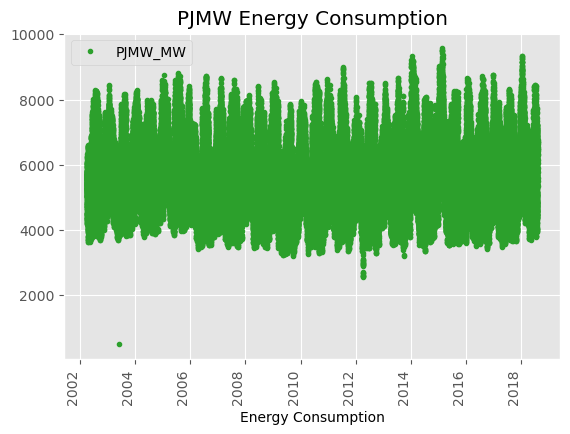

In [4]:
df.plot(style = '.', color = color_pal[2], title = 'PJMW Energy Consumption')
plt.xlabel('Energy Consumption')
plt.xticks(rotation = 90)
plt.show()

<Axes: xlabel='PJMW_MW', ylabel='Count'>

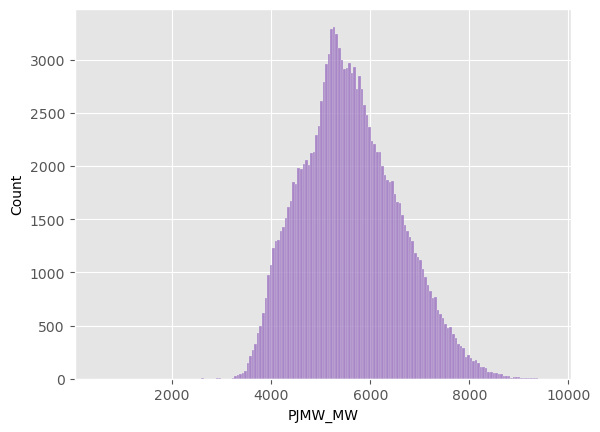

In [5]:
sns.histplot(data =df, x = df['PJMW_MW'], color=color_pal[4])

Text(0, 0.5, '')

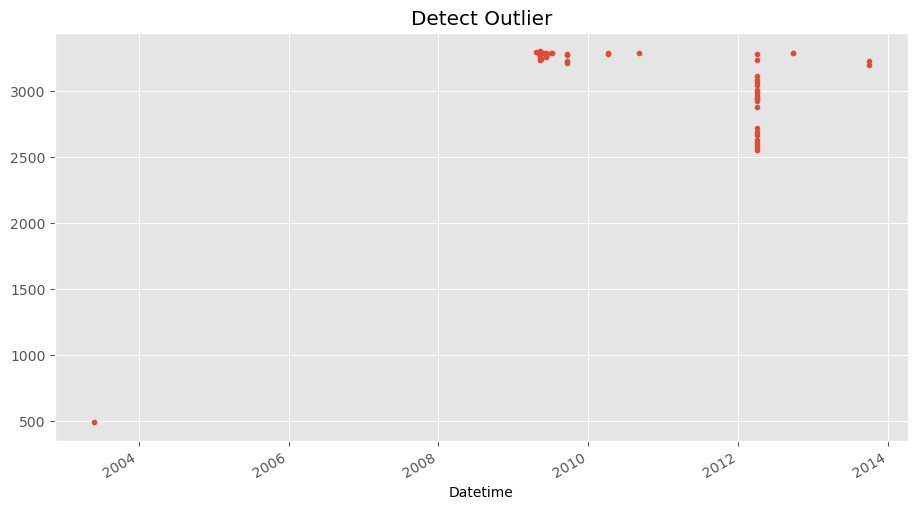

In [6]:
df.query('PJMW_MW < 3_300')['PJMW_MW'].plot(figsize = (11,6), title = 'Detect Outlier', style = '.')
plt.ylabel('')

In [7]:
df_copy = df.query('PJMW_MW > 2_500').copy()

## Train/Test Split

In [8]:
train = df_copy.loc[df_copy.index < '2015-01-01']
test = df_copy.loc[df_copy.index >= '2015-01-01']

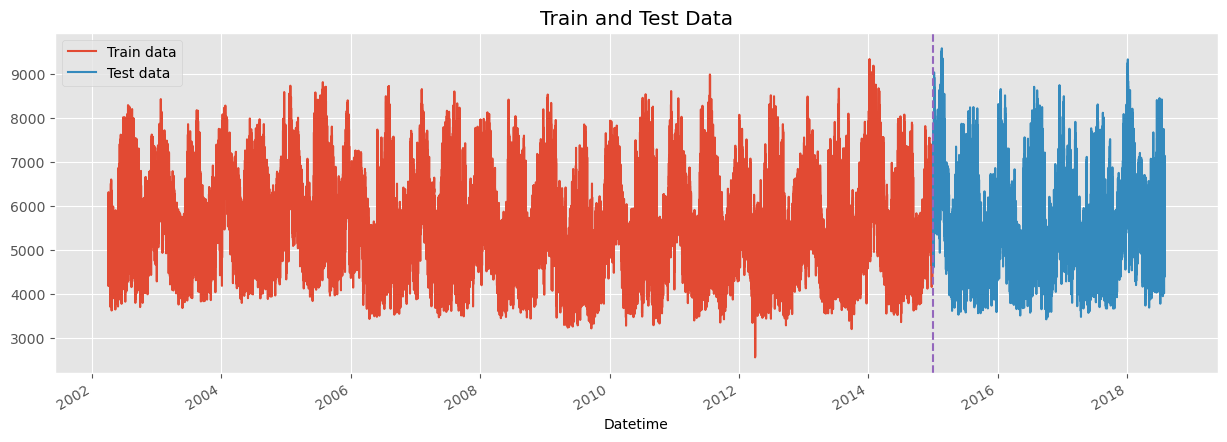

In [9]:
fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, label = 'Training Plot', title = 'Train and Test Data')
test.plot(ax = ax, label = 'Test Plot')
ax.legend(['Train data', 'Test data'])
ax.axvline(x = df_copy.index[df_copy.index == '2015-01-01'], ls = '--', color = color_pal[4])
plt.show()

## Time Series Cross Validation

In [10]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=365*24*1, gap = 24)

In [11]:
df_copy = df_copy.sort_index()

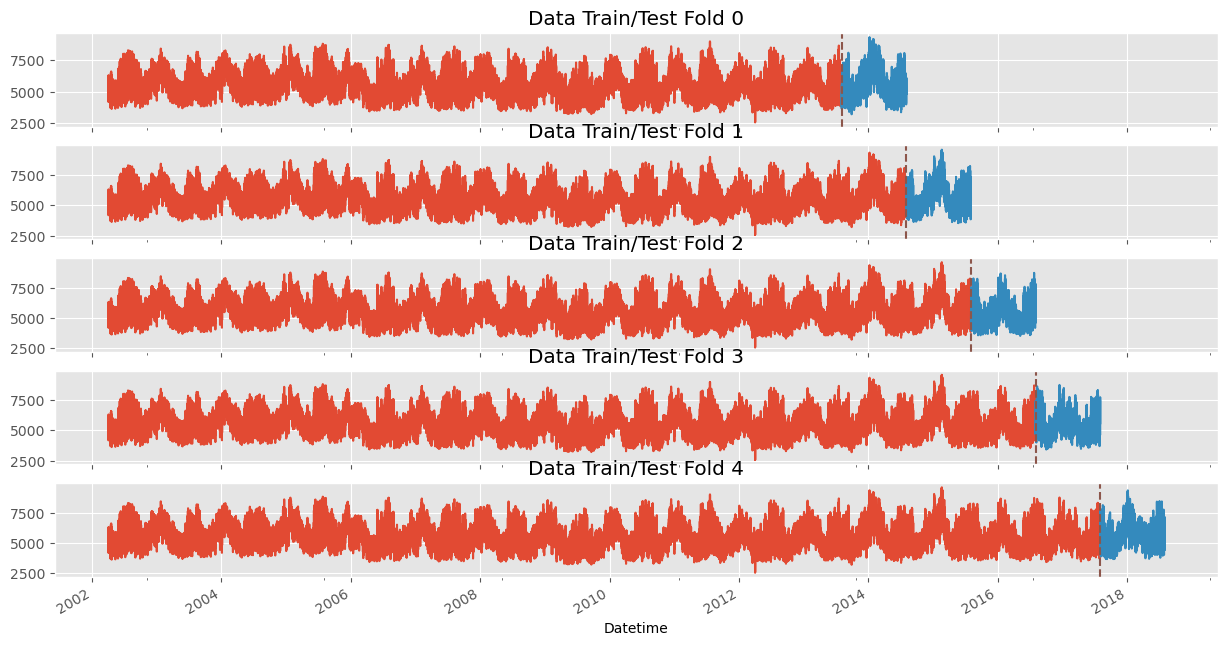

In [12]:
fig, axs = plt.subplots(5,1, figsize = (15,8), sharex = True)

fold = 0
for train_indx, val_indx in tss.split(df_copy):
        train = df_copy.iloc[train_indx]
        test = df_copy.iloc[val_indx]
        train['PJMW_MW'].plot(ax=axs[fold], title = f'Data Train/Test Fold {fold}', label = 'Training Set')
        test['PJMW_MW'].plot(ax=axs[fold], label = 'Test Set')
        axs[fold].axvline(test.index.min(), ls = '--', color = color_pal[5])
        fold += 1

plt.show()

## Forecasting Horizon

The Forecasting Horizon is the length time into the future for which forecast are to be prepared.

In [13]:
def create_features (data):
    
    data = data.copy()
    data['Hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    data['weekofyear'] = data.index.isocalendar().week
    return data

df2 = create_features(df_copy)

## Lag Features

A values at prior timestamp that are considered useful due to they are created on an assumption that what happened in the past could influence sort of intrinsic information about the future.

In [14]:
def add_lag (data):
    target_map = df['PJMW_MW'].to_dict()
    data['lag1'] = (data.index - pd.Timedelta('364 days')).map(target_map)
    data['lag2'] = (data.index - pd.Timedelta('728 days')).map(target_map)
    data['lag3'] = (data.index - pd.Timedelta('1092 days')).map(target_map)
    return data

In [15]:
df_lag = add_lag(df2)

## Train Using Cross Validation

In [ ]:
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

tss = TimeSeriesSplit(n_splits=5, test_size=365*24*1, gap = 24)
df_lag = df_lag.sort_index()

fold = 0
pred = []
scores = []
for train_indx, val_indx in tss.split(df_lag):
    train = df_lag.iloc[train_indx]
    test = df_lag.iloc[val_indx]
    
    train = create_features(train)
    test = create_features(test)
    
    features = ['Hour', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear', 'dayofmonth', 'lag1', 'lag2', 'lag3']
    label = 'PJMW_MW'
    
    X_train = train[features]
    y_train = train[label]
    
    X_test = test[features]
    y_test = test[label]
    
    reg = XGBRegressor(n_estimators = 2000, max_depth = 3, objective = 'reg:linear', early_stopping_rounds = 50, learning_rate = 0.001, booster = 'gbtree')
    
    reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)
    
    y_pred = reg.predict(X_test)
    pred.append(y_pred)
    score = np.sqrt(mean_squared_error (y_test, y_pred))
    scores.append(score)

[16:51:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5676.16878	validation_1-rmse:5738.66962
[100]	validation_0-rmse:5143.04561	validation_1-rmse:5216.35860
[200]	validation_0-rmse:4661.32717	validation_1-rmse:4745.39048
[300]	validation_0-rmse:4226.14882	validation_1-rmse:4320.63201
[400]	validation_0-rmse:3833.11571	validation_1-rmse:3936.99224
[500]	validation_0-rmse:3478.24334	validation_1-rmse:3590.83254
[600]	validation_0-rmse:3157.89903	validation_1-rmse:3279.58105
[700]	validation_0-rmse:2868.96402	validation_1-rmse:2998.92492
[800]	validation_0-rmse:2608.44046	validation_1-rmse:2746.06809
[900]	validation_0-rmse:2373.63120	validation_1-rmse:2518.06470
[1000]	validation_0-rmse:2162.29800	validation_1-rmse:2312.57857
[1100]	validation_0-rmse:1972.27958	validation_1-rmse:2128.20972
[

In [ ]:
print (f'RMSE score accros fold {np.mean(scores):0.4f}')
print(f'RMSE score each fold {scores}')

In [ ]:
Fold = [1,2,3,4,5]
fold_result= pd.Series(data = scores, index = Fold)

In [ ]:
fold_result.sort_values(ascending = False).plot(kind = 'barh', color = color_pal[1])
plt.xlabel('RMSE score')
plt.ylabel('Nth Folds')
plt.title('RMSE Score each XGB folds')

## Future Prediction

- Retaining on all data
- Need an empty dataset for predict future 
- Run those dates through feature creation code + lag creation

In [ ]:
# Retaining on all data

df_lag = create_features(df_lag)

features = ['Hour', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear', 'dayofmonth', 'lag1', 'lag2', 'lag3']
label = 'PJMW_MW'

X_all = df_lag[features]
y_all = df_lag[label]

reg = XGBRegressor(booster = 'gbtree', max_depth = 3, n_estimators = 2000, learning_rate = 0.1, objective = 'reg:linear')

reg.fit(X_all, y_all, eval_set = [(X_all, y_all)], verbose = 50)

In [ ]:
# end date in df_lag
df_lag.index.max()

In [ ]:
# Create future dataset

future = pd.date_range('2018-08-03', '2019-08-01', freq = '1h')
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
df_lag['isFuture'] = False
df_and_future = pd.concat([df_lag, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lag(df_and_future)
df_and_future

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

## Predict the Future

In [ ]:
future_w_features['pred'] =  reg.predict(future_w_features[features])

In [ ]:
future_w_features['pred'].plot(figsize =  (13,5), title = 'Future Prediction',  color = color_pal[2], ms = 1)
plt.show()

In [ ]:
fig, ax = plt.subplots (figsize = (10,7))

df2['PJMW_MW'].plot(ax = ax, label = 'Present Plot')
future_w_features['pred'].plot(ax = ax)
ax.legend(['Recent Record', 'Prediction Record'])
plt.show()

## How to save model (BONUS)

In [ ]:
reg.save_model('XGBregressor.json')

In [ ]:
reg_new = XGBRegressor()
reg_new.load_model('XGBregressor.json')
future_w_features['pred'] = reg_new.predict(future_w_features[features])
future_w_features['pred'].plot(figsize = (13,5), color = color_pal[3], ms = 1, lw = 1, title = 'Future Prediction')